### Release month vs profit

I looked at each table to make note of all available columns. I noticed the tconst and nconst columns that I counld use to merge all of the data together into one dataframe. After merging, I dropped many columns that I did not need. These included columns that I though contained duplicate information or information that would not be useful. Next, I dropped rows with null values in a subset of all columns. I used outer merges so there where lots of rows with missing data. I wanted to be sure of the data that I had before getting rid of any. I also did not want to drop rows that were only missing data in either domestic or worldwide gross because I only needed one.

The first plot shows the total profit made per release month. The second shows the total number of movies released per month. I suspected that the beginning of the summer would be where the most money was made and when most movies were released. It looks like June movies made the most money, December has the higher number of movies released.

This plot suggests the best month to release a movie of a given genre.

In [1]:
# Import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

In [2]:
#load data
nb = pd.read_csv('data/zippedData/imdb.name.basics.csv.gz')
takas = pd.read_csv('data/zippedData/imdb.title.akas.csv.gz')
tbase = pd.read_csv('data/zippedData/imdb.title.basics.csv.gz')
tbase = pd.read_csv('data/zippedData/imdb.title.basics.csv.gz')
tcrew = pd.read_csv('data/zippedData/imdb.title.crew.csv.gz')
tprinc = pd.read_csv('data/zippedData/imdb.title.principals.csv.gz')
trat = pd.read_csv('data/zippedData/imdb.title.ratings.csv.gz')
tn = pd.read_csv('data/zippedData/tn.movie_budgets.csv.gz')

In [3]:
#rename takas['title_id'] to takas['tconst'] to that we can use it to merge on
takas.rename(columns={'title_id':'tconst'},inplace=True)
#merge data
tcombo = trat.merge(tcrew,how='outer',on='tconst')
tcombo = tcombo.merge(tbase,how='outer',on='tconst')
tcombo = tcombo.merge(takas,how='outer',on='tconst')
tcombo = tcombo.merge(tprinc,how='outer',on='tconst')
tcombo = tcombo.merge(nb,how='outer',on='nconst')

#change tcombo['primary_title'] to movie
tcombo.rename(columns={'primary_title':'movie'},inplace=True)
#finish merging
tcombo = tcombo.merge(tn,how='outer',on='movie')
#drop some columns
tcombo.drop(['language','types','attributes','is_original_title','ordering_x','ordering_y','original_title','numvotes','birth_year','death_year'],axis=1,inplace=True)
#drop null values from this subset of columns
tcombo.dropna(subset=['tconst','averagerating','directors','writers','movie','start_year','runtime_minutes','genres','title','region','id','release_date','production_budget'],inplace=True)

#I had lots of duplicates so I dropped the dupes in tconst and movie columns
tcombo.drop_duplicates(subset=['tconst','movie'],inplace=True)

#change budget and gross types to int
tcombo['production_budget'] = tcombo['production_budget'].map(lambda x: x.replace('$',""))
tcombo['production_budget'] = tcombo['production_budget'].map(lambda x: x.replace(',',""))
tcombo['domestic_gross'] = tcombo['domestic_gross'].map(lambda x: x.replace('$',""))
tcombo['domestic_gross'] = tcombo['domestic_gross'].map(lambda x: x.replace(',',""))
tcombo['worldwide_gross'] = tcombo['worldwide_gross'].map(lambda x: x.replace('$',""))
tcombo['worldwide_gross'] = tcombo['worldwide_gross'].map(lambda x: x.replace(',',""))
tcombo.production_budget = tcombo.production_budget.astype(float)
tcombo.domestic_gross = tcombo.domestic_gross.astype(float)
tcombo.worldwide_gross = tcombo.worldwide_gross.astype(float)

#making a new column called release month
tcombo['release_month'] = tcombo['release_date'].map(lambda x: x[:3])

#make profit column
tcombo['profit'] = (tcombo['worldwide_gross'] - tcombo['production_budget'])

#drop rows in gross and budget that are zero
tcombo = tcombo.loc[((tcombo['domestic_gross'] != 0) | (tcombo['worldwide_gross'] != 0)) & (tcombo['production_budget'] != 0)]

I define an order that I want the months to show up in and then, make the column values categorical and pass in the sort order. Next, I sort by the release month and make a histogram showing the number of movies released per month.

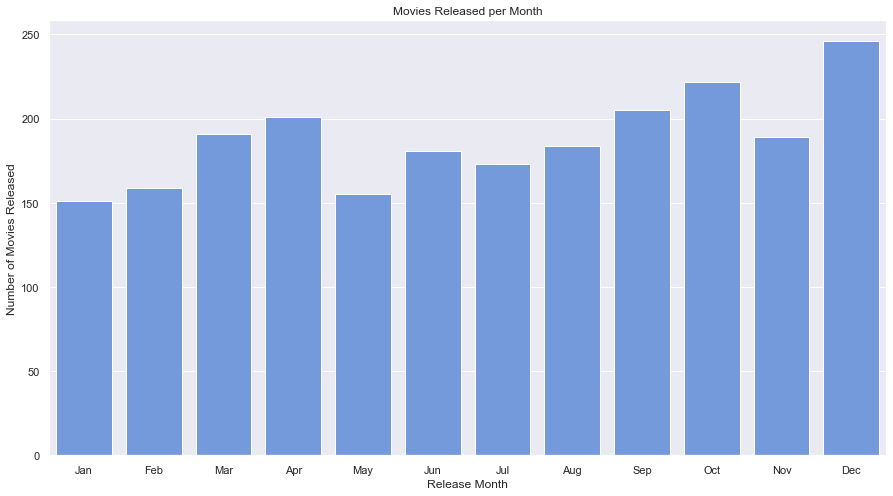

In [4]:
#define an order for the months
month_order = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
#make the months categorical and pass the order that they should appear
tcombo['release_month'] = pd.Categorical(tcombo['release_month'], month_order)
#sort by release month
tcombo = tcombo.sort_values(by='release_month',ascending=False)
#make the plot
sns.set(rc={'figure.figsize':(15,8)})   

ax = sns.countplot(x='release_month',data=tcombo,color='cornflowerblue')
#how many movies are released each month
ax.set(xlabel='Release Month',ylabel='Number of Movies Released',title='Movies Released per Month');

#### Best Movie Genres to Release per Month

First, I make a new dataframe with the genres, release months, and profits. The genres are in a comma separated string so I split them on the comma and then use .explode on the lists so that each genre is in its own row.

In [5]:
release_genre = tcombo[['genres','release_month','profit']]
release_genre[:]['genres'] = release_genre['genres'].str.split(',')
release_genre = release_genre.explode('genres')

release_genre.dropna(axis=0,how='any',subset=['profit'],inplace=True)

I wrote this function to return the total profit per genre of movies in a given month.

In [6]:
#returns the profit of each genre sorted descending for the given month
def month_profit_sum(month,release_genre):
    month_profit = release_genre.loc[release_genre['release_month'] == month]
    
    #removed this line so that it is not grouped by release month anymore
    #    month_profit = month_profit.groupby(['release_month','genres']).sum()
    
    month_profit_sum = month_profit.groupby(['genres']).sum()
    month_profit_sum.dropna(axis=0,how='any',subset=['profit'],inplace=True)
    
    month_profit_sum = month_profit_sum.sort_values(by='profit',ascending=False)
    
    return month_profit_sum

It is interesting to see which genres are most profitable per month. For example: October-Thriller ; February-Romance is 5th

Maybe October is spooky month, February is romance month, and everything else is action/adventure.

I wrote a for loop to make a bar plot showing the profitable genres by month.

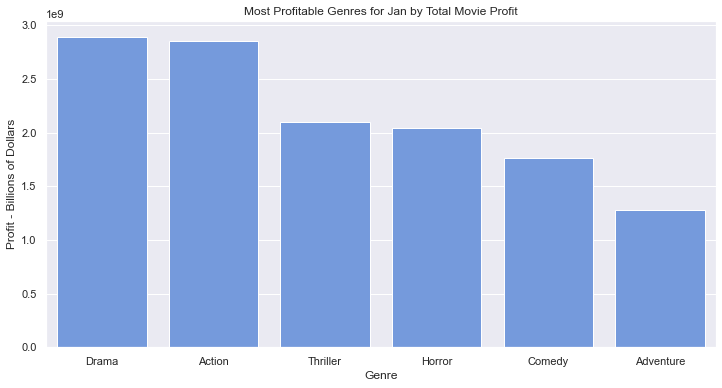

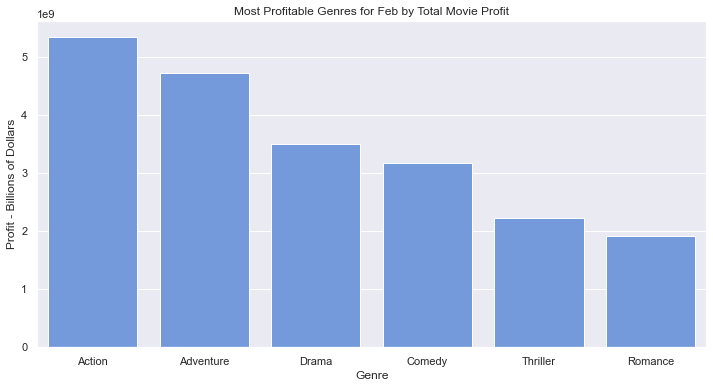

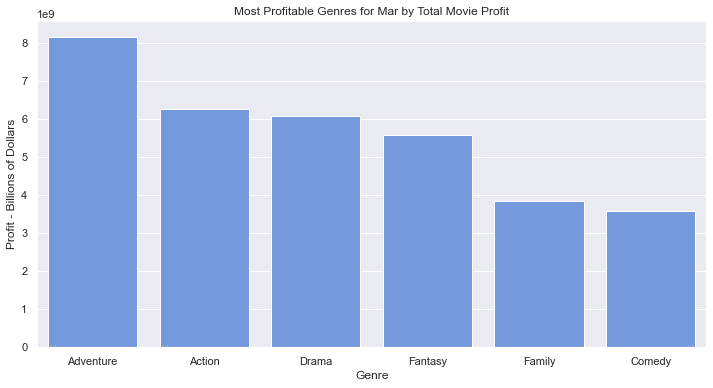

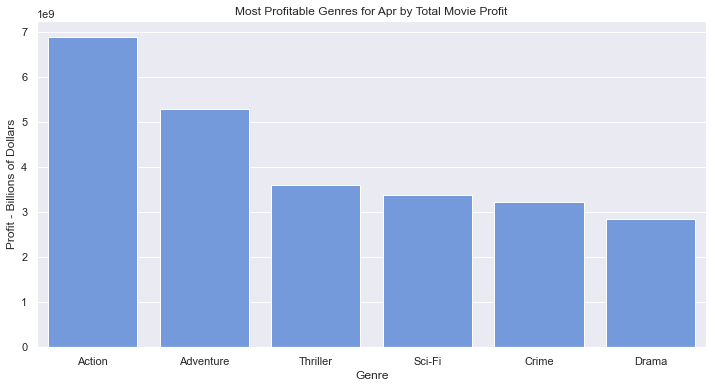

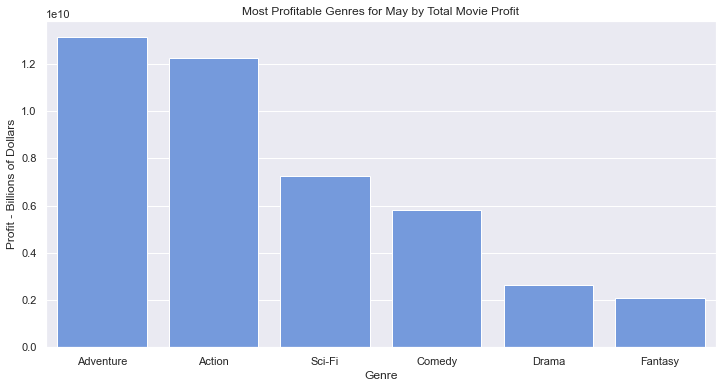

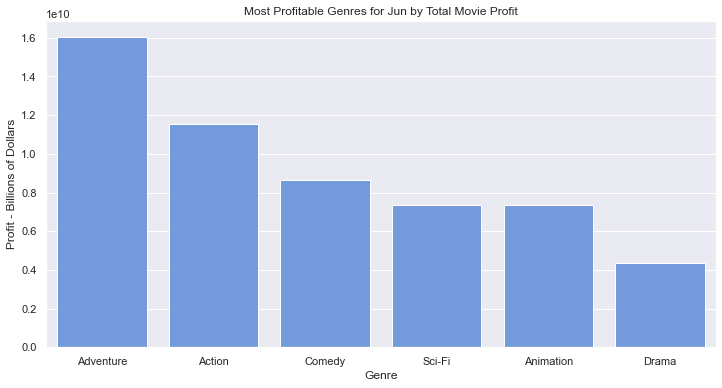

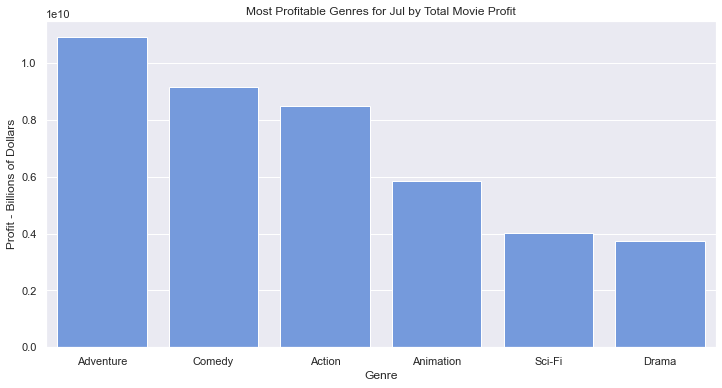

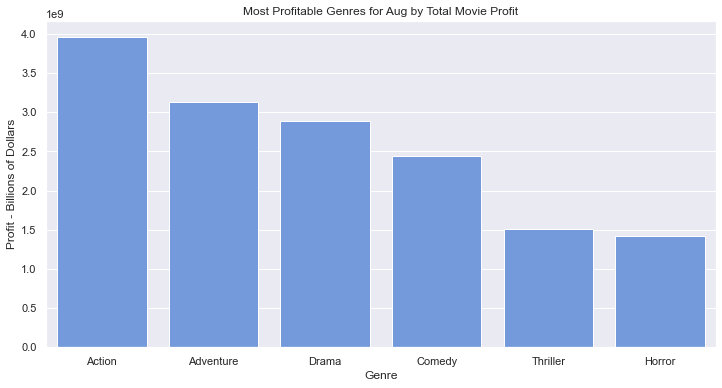

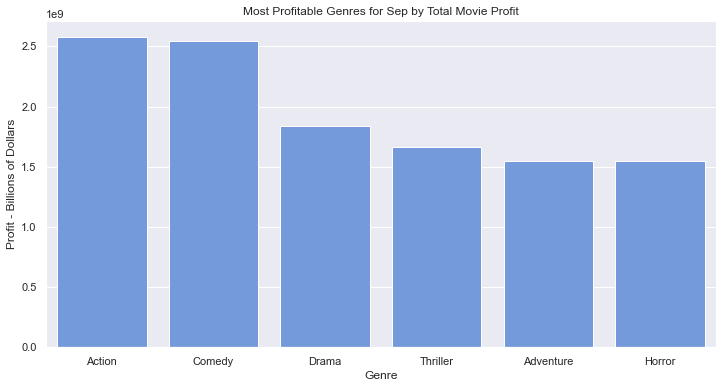

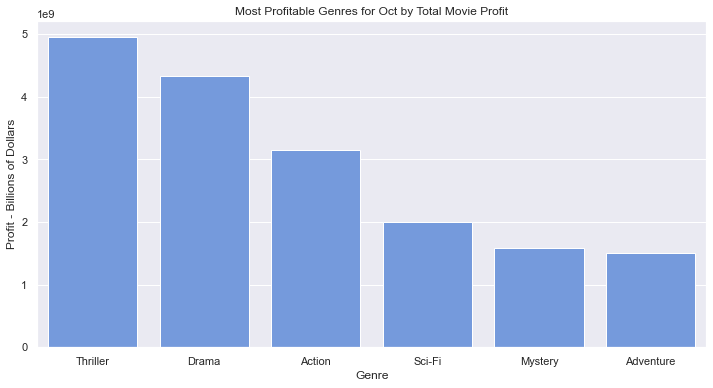

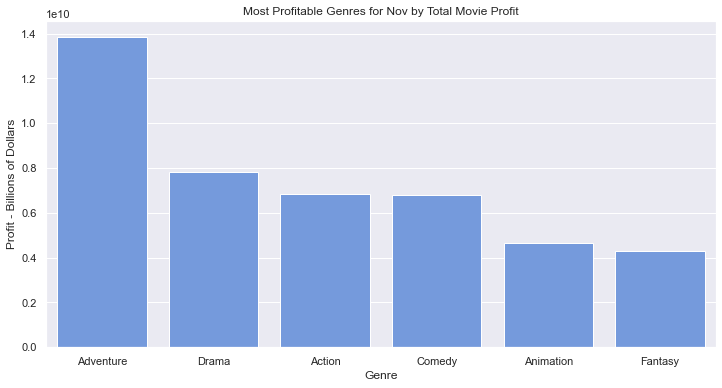

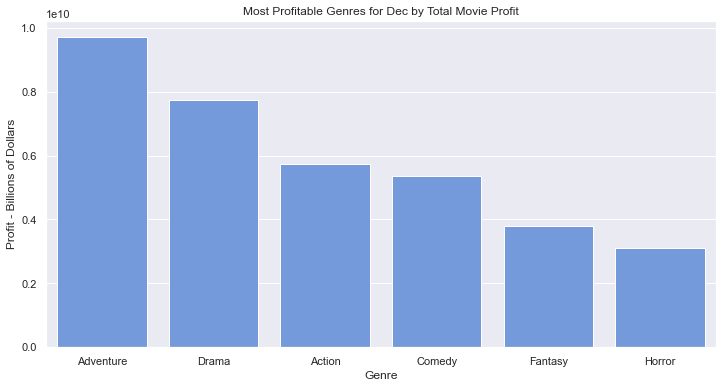

In [8]:
month_order = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

months_to_get = ['Feb','Oct']
#makes a plot of top genres for each month passed to it
for month in month_order:
    
    fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,6))

    
    df=month_profit_sum(month,release_genre)
    df = df[:6]
    #print(df)
    #print(df.index)
    
    ax = sns.barplot(x=df.index,y='profit',data=df,color='cornflowerblue')
    ax.set(xlabel='Genre',ylabel='Profit - Billions of Dollars',title=f'Most Profitable Genres for {month.title()} by Total Movie Profit')
    